In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision import models, transforms
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f = open("data/dataset_info.txt", "r")
labels = f.readlines()[1:]
f.close()

name_label = {}
lb_list = []

for i in range(len(labels)):
    lb = labels[i].replace("\n", "").strip().split(". ")[1]
    lb_list.append(lb)
    name_label[lb] = 0
    
for i in range(len(lb_list)):
    name_label[lb_list[i]] += i
    
label_name = list(name_label.keys())


In [3]:
class LoadImageDataset(Dataset):
    def __init__(self, imgname_labels_file, img_dir, transform_data = None, train = True):
        self.df_imgname_labels = pd.read_csv(imgname_labels_file)[:100]
        self.img_dir = img_dir
        self.transform_data =  transform_data
        self.train = train
        
    def __len__(self):
        return len(self.df_imgname_labels)
    
    def __getitem__(self, idx):
        path = self.img_dir + self.df_imgname_labels.iloc[idx, 0]
        img =  read_image(path)/ 255.
        result = {"image": img, "label": -1}
        if self.train:
            lb = self.df_imgname_labels.iloc[idx, 1]
            result["label"] = lb
            if self.transform_data:
                result["label"] = self.transform_data['labels'](result["label"])
                result["image"] = self.transform_data['images'](result["image"])
        else:
            lb = 0
            result["label"] = lb
            if self.transform_data: 
                result["image"] = self.transform_data['images'](result["image"])
        
        return result

## Basic Network

In [4]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 2304, out_features = 1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = 1024, out_features = len(name_label), bias = True),
            nn.Softmax()
        )
    def forward(self, x):
        return self.model(x)

In [5]:
def train(path = "data/", batch_size = 8, epochs = 20):
    loss_arr = []
     
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print("Using {} device".format(device))
    model = MyNetwork().to(device)
    print(model)
    
    transform_data =  {
        'images': 
                transforms.Compose([
                transforms.Resize((256, 256), interpolation = transforms.functional.InterpolationMode.BICUBIC),
                transforms.CenterCrop((224, 224)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ]),
        'labels': 
                transforms.Compose([
                transforms.Lambda(lambda y: name_label[y])
                ])
    }
   
    train_dataloader = DataLoader(LoadImageDataset(path + "train.csv", path + "train_images/", transform_data), batch_size = batch_size,  num_workers=2, shuffle=True)
    
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    for epoch in range(epochs):
        total_loss = 0
        
        for  dic in train_dataloader:
            X = dic["image"].to(device)
            y = dic["label"].to(device)
            
            # forward pass
            y_preds = model(X)
#             print(y_preds.shape)
            loss = loss_fun(y_preds, y)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
           
        total_loss /= len(train_dataloader.dataset)
        loss_arr.append(total_loss)
        print("Epoch: "+ str(epoch+1) + " | loss: "+str(total_loss), flush = True)
   
    
    return loss_arr


def plot(loss_arr):
    ind = np.arange(1, len(loss_arr)+1)
    plt.plot(ind, np.array(loss_arr))


Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=62, bias=True)
    (10): Softmax(dim=None)
  )
)


/home/avani.gupta/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | loss: 0.5349198842048645
Epoch: 2 | loss: 0.5265533208847046
Epoch: 3 | loss: 0.5289556360244752
Epoch: 4 | loss: 0.528790922164917
Epoch: 5 | loss: 0.5287669181823731
Epoch: 6 | loss: 0.5284537553787232
Epoch: 7 | loss: 0.5288408708572387
Epoch: 8 | loss: 0.5275613832473754
Epoch: 9 | loss: 0.527986249923706
Epoch: 10 | loss: 0.5263271760940552
Epoch: 11 | loss: 0.5275632429122925
Epoch: 12 | loss: 0.5263085412979126
Epoch: 13 | loss: 0.5275659132003784
Epoch: 14 | loss: 0.5275439071655273
Epoch: 15 | loss: 0.5275594806671142
Epoch: 16 | loss: 0.5275489091873169
Epoch: 17 | loss: 0.5275528573989868
Epoch: 18 | loss: 0.5262542700767517
Epoch: 19 | loss: 0.5269930577278137
Epoch: 20 | loss: 0.5275774049758911


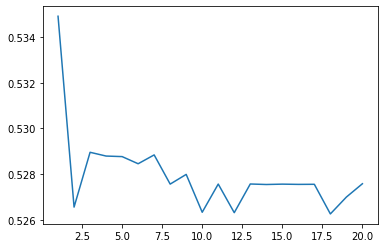

In [6]:
epochs = 20
loss_arr = train(epochs = epochs)
plot(loss_arr)

## Playing with layers

### Add BatchNorm

In [7]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 6),
            nn.MaxPool2d(kernel_size = (4,4)),
           
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 16),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            
            nn.Linear(in_features = 2304, out_features = 1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = 1024, out_features = len(name_label), bias = True),
            nn.Softmax()
        )
    def forward(self, x):
        return self.model(x)

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2304, out_features=1024, bias=True)
    (10): ReLU()
    (11): Linear(in_features=1024, out_features=62, bias=True)
    (12): Softmax(dim=None)
  )
)


/home/avani.gupta/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | loss: 0.5294662547111512
Epoch: 2 | loss: 0.5207396554946899
Epoch: 3 | loss: 0.5185131120681763
Epoch: 4 | loss: 0.5177706718444824
Epoch: 5 | loss: 0.52215101480484
Epoch: 6 | loss: 0.5167118382453918
Epoch: 7 | loss: 0.5142892932891846
Epoch: 8 | loss: 0.5120230627059936
Epoch: 9 | loss: 0.5122046756744385
Epoch: 10 | loss: 0.5087532377243043
Epoch: 11 | loss: 0.5062459111213684
Epoch: 12 | loss: 0.5081772589683533
Epoch: 13 | loss: 0.5145453858375549
Epoch: 14 | loss: 0.5154542112350464
Epoch: 15 | loss: 0.5137864470481872
Epoch: 16 | loss: 0.5113722681999207
Epoch: 17 | loss: 0.5151143455505371
Epoch: 18 | loss: 0.513773729801178
Epoch: 19 | loss: 0.5154927682876587
Epoch: 20 | loss: 0.5152896451950073


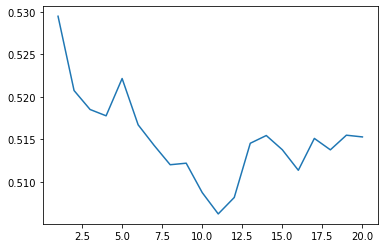

In [8]:
epochs = 20
loss_arr = train(epochs = epochs)
plot(loss_arr)

### Without pooling

In [9]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features = 746496, out_features = len(name_label), bias=False),
        )
    def forward(self, x):
        return self.model(x)

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=746496, out_features=62, bias=False)
  )
)
Epoch: 1 | loss: 3.5349454832077027
Epoch: 2 | loss: 0.2453252410888672
Epoch: 3 | loss: 0.07062227062880994
Epoch: 4 | loss: 0.02044912262033904
Epoch: 5 | loss: 0.006048456509597599
Epoch: 6 | loss: 0.0010929223269340582
Epoch: 7 | loss: 0.0006112567763921107
Epoch: 8 | loss: 9.152890623226995e-05
Epoch: 9 | loss: 7.794051671226044e-05
Epoch: 10 | loss: 0.00010644021381267521
Epoch: 11 | loss: 0.00011094260822574143
Epoch: 12 | loss: 0.00010697034254917525
Epoch: 13 | loss: 0.00011145824046252529
Epoch: 14 | loss: 0.0001248539309744956
Epoch: 15 | loss: 0.00013862023086403497
Epoch: 16 | loss: 0.00011405540280975401
Epoch: 17 | loss: 0.00011145526448672172
Epoch: 18 | loss: 0.00

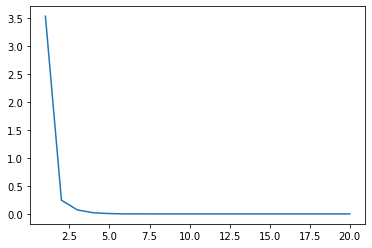

In [10]:
epochs = 20
loss_arr = train(epochs = epochs)
plot(loss_arr)

### Max-pool 

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=46656, out_features=62, bias=False)
  )
)
Epoch: 1 | loss: 1.0537453317642211
Epoch: 2 | loss: 0.4212511420249939
Epoch: 3 | loss: 0.23339530289173127
Epoch: 4 | loss: 0.049399748649448155
Epoch: 5 | loss: 0.013327822961146011
Epoch: 6 | loss: 0.002624251008965075
Epoch: 7 | loss: 0.00045503531699068843
Epoch: 8 | loss: 0.0005751359158603008
Epoch: 9 | loss: 0.0005116757155337837
Epoch: 10 | loss: 0.00037020807096268984


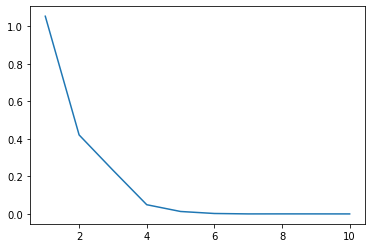

In [11]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 46656, out_features = len(name_label), bias=False),
        )
    def forward(self, x):
        return self.model(x)
    
epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=62, bias=False)
  )
)
Epoch: 1 | loss: 0.5400315642356872
Epoch: 2 | loss: 0.47163894414901736
Epoch: 3 | loss: 0.3820412349700928
Epoch: 4 | loss: 0.23894546151161195
Epoch: 5 | loss: 0.09391472645103932
Epoch: 6 | loss: 0.037984237596392634
Epoch: 7 | loss: 0.015744927981868388
Epoch: 8 | loss: 0.005489108599722386
Epoch: 9 | loss: 0.002417745778657263
Epoch: 10 | loss: 0.0008821867732331156


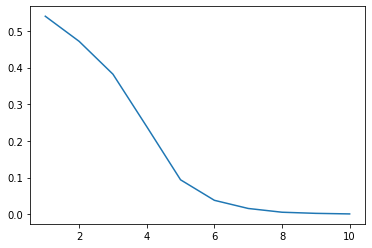

In [12]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 2304, out_features = len(name_label), bias=False),
        )
    def forward(self, x):
        return self.model(x)

    
epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)

### Avg Pool

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=512, bias=False)
    (8): Linear(in_features=512, out_features=62, bias=False)
  )
)
Epoch: 1 | loss: 0.5349948000907898
Epoch: 2 | loss: 0.45489207744598387
Epoch: 3 | loss: 0.3530518889427185
Epoch: 4 | loss: 0.22262844800949097
Epoch: 5 | loss: 0.11425527513027191
Epoch: 6 | loss: 0.061904635727405545
Epoch: 7 | loss: 0.035001732558012005
Epoch: 8 | loss: 0.02972656926140189
Epoch: 9 | loss: 0.015991474711336197
Epoch: 10 | loss: 0.007102768700569868


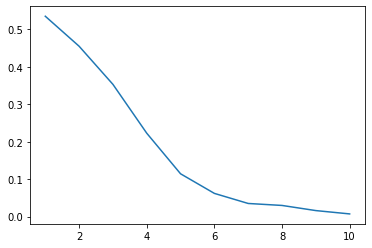

In [13]:


class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 2304, out_features = 512, bias=False),
            nn.Linear(in_features = 512, out_features = len(name_label), bias=False),
        )
    def forward(self, x):
        return self.model(x)

    
epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)



Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=512, bias=True)
    (8): Linear(in_features=512, out_features=62, bias=True)
  )
)
Epoch: 1 | loss: 0.5338493824005127
Epoch: 2 | loss: 0.4445702338218689
Epoch: 3 | loss: 0.3273104405403137
Epoch: 4 | loss: 0.1568203514814377
Epoch: 5 | loss: 0.0549690855294466
Epoch: 6 | loss: 0.03578449134714901
Epoch: 7 | loss: 0.03935745207592845
Epoch: 8 | loss: 0.022785753598436712
Epoch: 9 | loss: 0.01187285190448165
Epoch: 10 | loss: 0.0063646844192408025


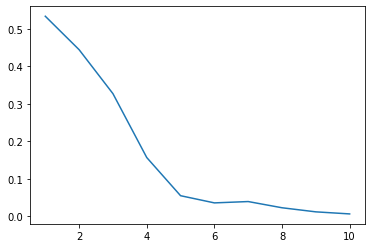

In [14]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 2304, out_features = 512, bias=True),
            nn.Linear(in_features = 512, out_features = len(name_label), bias=True),
        )
    def forward(self, x):
        return self.model(x)

    
epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)

## Adding more conv layers 

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9216, out_features=1024, bias=False)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=256, bias=False)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=62, bias=False)
  )
)
Epoch: 1 | loss: 0.5359687399864197
Epoch: 2 | loss: 0.507970187664032
Epoch: 3 | loss: 0.47648273944854735
Epoch: 4 | loss: 0.4572883129119873
Epoch: 5 | loss: 0.4256727719306946
Epoch: 6 | loss: 0.38233726263046264
Epoch: 7 | loss: 0.3087602519989014
Epoch: 8 | loss: 0.2041388636827469
Epoch: 9 | loss: 0.13887995064258576
Epoch: 10 | l

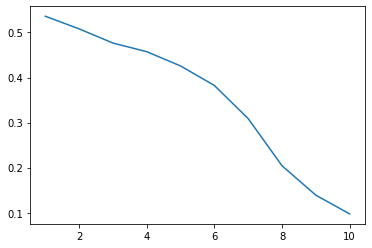

In [15]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 9216, out_features = 1024, bias=False),
            nn.ReLU(),
            nn.Linear(in_features = 1024, out_features = 256, bias=False),
            nn.ReLU(),
            nn.Linear(in_features = 256, out_features = len(name_label), bias=False),
        )
    def forward(self, x):
        return self.model(x)

    
epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9216, out_features=62, bias=False)
    (8): Softmax(dim=None)
  )
)


/home/avani.gupta/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | loss: 0.5325051927566529
Epoch: 2 | loss: 0.5275487232208252
Epoch: 3 | loss: 0.5275538277626037
Epoch: 4 | loss: 0.5250578641891479
Epoch: 5 | loss: 0.5276033639907837
Epoch: 6 | loss: 0.5275806331634522
Epoch: 7 | loss: 0.5263224363327026
Epoch: 8 | loss: 0.5275628995895386
Epoch: 9 | loss: 0.5263250446319581
Epoch: 10 | loss: 0.5250808906555176


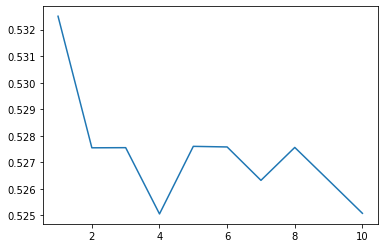

In [16]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 9216, out_features = len(name_label), bias=False),
            nn.Softmax()
        )
    def forward(self, x):
        return self.model(x)

    
epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9216, out_features=62, bias=False)
    (8): Softmax(dim=None)
  )
)


/home/avani.gupta/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | loss: 0.5355728197097779
Epoch: 2 | loss: 0.5241554737091064
Epoch: 3 | loss: 0.5199035906791687
Epoch: 4 | loss: 0.5139804267883301
Epoch: 5 | loss: 0.5211299014091492
Epoch: 6 | loss: 0.5210903882980347
Epoch: 7 | loss: 0.5201430892944336
Epoch: 8 | loss: 0.5186952328681946
Epoch: 9 | loss: 0.5199755001068115
Epoch: 10 | loss: 0.5190726590156555


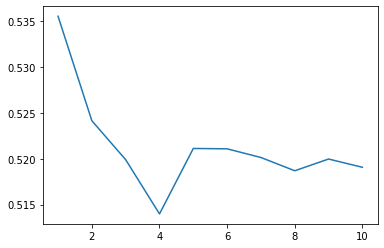

In [17]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 9216, out_features = len(map_name_label), bias=False),
           
        )
    def forward(self, x):
        return self.model(x)

    
epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9216, out_features=1024, bias=False)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=256, bias=False)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=62, bias=False)
    (12): Softmax(dim=None)
  )
)


/home/avani.gupta/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | loss: 0.5367322301864624
Epoch: 2 | loss: 0.5345879507064819
Epoch: 3 | loss: 0.5288313388824463
Epoch: 4 | loss: 0.5288313388824463
Epoch: 5 | loss: 0.5288313388824463
Epoch: 6 | loss: 0.5288313388824463
Epoch: 7 | loss: 0.5288313388824463
Epoch: 8 | loss: 0.5288313388824463
Epoch: 9 | loss: 0.5288313388824463
Epoch: 10 | loss: 0.5288313388824463


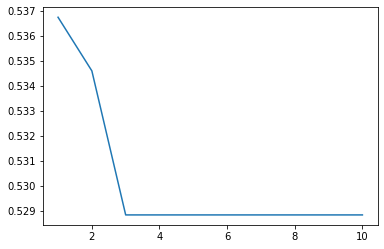

In [18]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 9216, out_features = 1024, bias=False),
            nn.ReLU(),
            nn.Linear(in_features = 1024, out_features = 256, bias=False),
            nn.ReLU(),
            nn.Linear(in_features = 256, out_features = len(name_label), bias=False),
            nn.Softmax()
        )
    def forward(self, x):
        return self.model(x)

    
epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9216, out_features=1024, bias=False)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=256, bias=False)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=62, bias=False)
    (12): Softmax(dim=None)
  )
)


/home/avani.gupta/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | loss: 0.5320544576644898
Epoch: 2 | loss: 0.5263313388824463
Epoch: 3 | loss: 0.5275813388824463
Epoch: 4 | loss: 0.5288313388824463
Epoch: 5 | loss: 0.5288313388824463
Epoch: 6 | loss: 0.5288313388824463
Epoch: 7 | loss: 0.5288313388824463
Epoch: 8 | loss: 0.5288313388824463
Epoch: 9 | loss: 0.5288313388824463
Epoch: 10 | loss: 0.5275813388824463


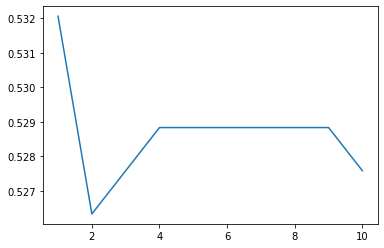

In [19]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 9216, out_features = len(map_name_label), bias=False),
        )
    def forward(self, x):
        return self.model(x)

    
epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)

## Playing with Activation functions

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=512, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): Sigmoid()
  )
)
Epoch: 1 | loss: 0.5355001568794251
Epoch: 2 | loss: 0.5121035265922547
Epoch: 3 | loss: 0.5042818069458008
Epoch: 4 | loss: 0.5035944390296936
Epoch: 5 | loss: 0.502338035106659
Epoch: 6 | loss: 0.5021861124038697
Epoch: 7 | loss: 0.5013333630561828
Epoch: 8 | loss: 0.5030652070045472
Epoch: 9 | loss: 0.5013271164894104
Epoch: 10 | loss: 0.5019368577003479


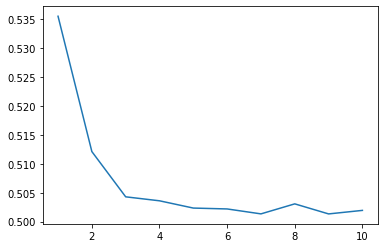

In [20]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 2304, out_features = 512, bias=True),
            nn.Sigmoid(),
            nn.Linear(in_features = 512, out_features = len(name_label), bias=True),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.model(x)

    
epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=512, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): Sigmoid()
  )
)
Epoch: 1 | loss: 0.5340457224845886
Epoch: 2 | loss: 0.5099646639823914
Epoch: 3 | loss: 0.5043559861183167
Epoch: 4 | loss: 0.503445565700531
Epoch: 5 | loss: 0.5032819056510925
Epoch: 6 | loss: 0.5032294058799743
Epoch: 7 | loss: 0.5010610342025756
Epoch: 8 | loss: 0.5004717111587524
Epoch: 9 | loss: 0.5006674385070801
Epoch: 10 | loss: 0.4997899270057678


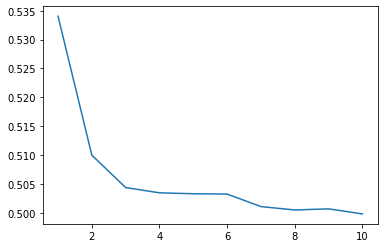

In [21]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 2304, out_features = 512, bias=True),
            nn.Sigmoid(),
            nn.Linear(in_features = 512, out_features = len(map_name_label), bias=True),
            
        )
    def forward(self, x):
        return self.model(x)

    
epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=512, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=512, out_features=62, bias=True)
  )
)
Epoch: 1 | loss: 0.5313963150978088
Epoch: 2 | loss: 0.4683868932723999
Epoch: 3 | loss: 0.40100305795669555
Epoch: 4 | loss: 0.2892147493362427
Epoch: 5 | loss: 0.18930746674537657
Epoch: 6 | loss: 0.11620538592338563
Epoch: 7 | loss: 0.05996110625565052
Epoch: 8 | loss: 0.04195841625332832
Epoch: 9 | loss: 0.04618318485096097
Epoch: 10 | loss: 0.03719288640655577


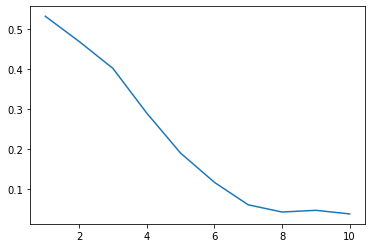

In [22]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 2304, out_features = 512, bias=True),
            nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.Linear(in_features = 512, out_features = len(name_label), bias=True),
            
        )
    def forward(self, x):
        return self.model(x)

    
epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
  )
)
Epoch: 1 | loss: 0.5323517727851867
Epoch: 2 | loss: 0.4661682105064392
Epoch: 3 | loss: 0.3940266180038452
Epoch: 4 | loss: 0.2889683449268341
Epoch: 5 | loss: 0.179590106010437
Epoch: 6 | loss: 0.09333199337124824
Epoch: 7 | loss: 0.05317548587918282
Epoch: 8 | loss: 0.04662277322262526
Epoch: 9 | loss: 0.03353924550116062
Epoch: 10 | loss: 0.019070525001734496


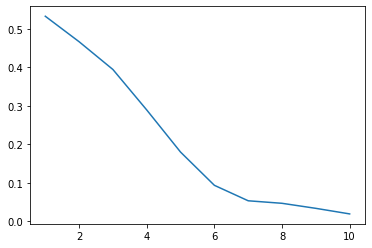

In [23]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 2304, out_features = 512, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features = len(name_label), bias=True),
        
            
        )
    def forward(self, x):
        return self.model(x)

    
epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=512, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=512, out_features=62, bias=True)
  )
)
Epoch: 1 | loss: 0.593679780960083
Epoch: 2 | loss: 0.49148271083831785
Epoch: 3 | loss: 0.4771981906890869
Epoch: 4 | loss: 0.47296311140060426
Epoch: 5 | loss: 0.46793240547180176
Epoch: 6 | loss: 0.4624021315574646
Epoch: 7 | loss: 0.4518798995018005
Epoch: 8 | loss: 0.4336570978164673
Epoch: 9 | loss: 0.41259313583374024
Epoch: 10 | loss: 0.3943023943901062


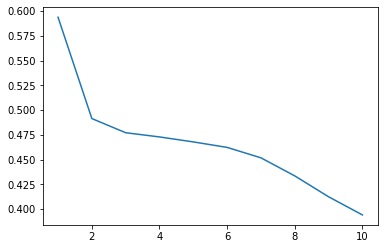

In [24]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 2304, out_features = 512, bias=True),
            nn.Sigmoid(),
            nn.Linear(in_features = 512, out_features = len(name_label), bias=True),

            
        )
    def forward(self, x):
        return self.model(x)

    
epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
  )
)
Epoch: 1 | loss: 0.5343277478218078
Epoch: 2 | loss: 0.48229594945907595
Epoch: 3 | loss: 0.4294613075256348
Epoch: 4 | loss: 0.3601236844062805
Epoch: 5 | loss: 0.22833302974700928
Epoch: 6 | loss: 0.181205123513937
Epoch: 7 | loss: 0.10575802147388458
Epoch: 8 | loss: 0.06218472521752119
Epoch: 9 | loss: 0.03550680015236139
Epoch: 10 | loss: 0.01991024725139141


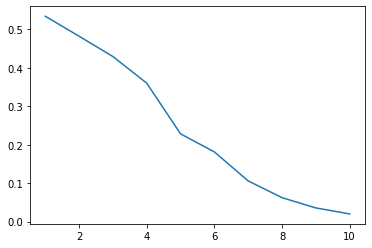

In [25]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 2304, out_features = 512, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features = len(name_label), bias=True)
            
        )
    def forward(self, x):
        return self.model(x)

    
epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): Softmax(dim=None)
  )
)


/home/avani.gupta/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | loss: 0.5334133720397949
Epoch: 2 | loss: 0.5288181734085083
Epoch: 3 | loss: 0.5277900886535645
Epoch: 4 | loss: 0.5251370525360107
Epoch: 5 | loss: 0.5273018598556518
Epoch: 6 | loss: 0.529881796836853
Epoch: 7 | loss: 0.5254296326637268
Epoch: 8 | loss: 0.5242197322845459
Epoch: 9 | loss: 0.5258523035049438
Epoch: 10 | loss: 0.5256007242202759


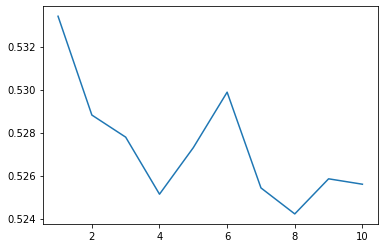

In [26]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 2304, out_features = 512, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features = len(name_label), bias=True),
            nn.Softmax()
            
        )
    def forward(self, x):
        return self.model(x)

epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): Softmax(dim=None)
  )
)


/home/avani.gupta/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | loss: 0.5305739712715148
Epoch: 2 | loss: 0.5272856330871583
Epoch: 3 | loss: 0.5255815744400024
Epoch: 4 | loss: 0.5258797812461853
Epoch: 5 | loss: 0.5245063161849975
Epoch: 6 | loss: 0.5229422903060913
Epoch: 7 | loss: 0.5229467582702637
Epoch: 8 | loss: 0.5268557667732239
Epoch: 9 | loss: 0.5285160565376281
Epoch: 10 | loss: 0.5294783210754395


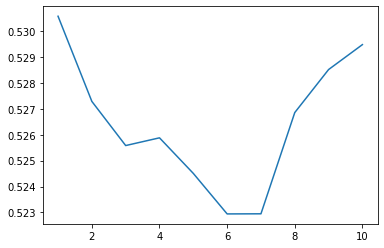

In [27]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            nn.Linear(in_features = 2304, out_features = 512, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features = len(name_label), bias=True),
            nn.Softmax()
            
        )
    def forward(self, x):
        return self.model(x)

epochs = 10
loss_arr = train(epochs = epochs)
plot(loss_arr)

## Different optimizer

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): Softmax(dim=None)
  )
)


/home/avani.gupta/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | loss: 0.5333965682983398
Epoch: 2 | loss: 0.5281901454925537
Epoch: 3 | loss: 0.5257142400741577
Epoch: 4 | loss: 0.5250210380554199
Epoch: 5 | loss: 0.5242484378814697
Epoch: 6 | loss: 0.5217216634750366
Epoch: 7 | loss: 0.5213362693786621
Epoch: 8 | loss: 0.5209984850883483
Epoch: 9 | loss: 0.5187482976913452
Epoch: 10 | loss: 0.5182714343070984


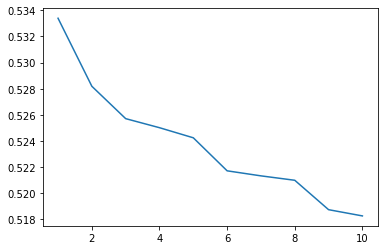

In [28]:
def train(type_optimizer= 'Adam', path = "data/", batch_size = 8, epochs = 20):
    loss_arr = []
     
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print("Using {} device".format(device))
    model = MyNetwork().to(device)
    print(model)
    
    transform_data =  {
        'images': 
                transforms.Compose([
                transforms.Resize((256, 256), interpolation = transforms.functional.InterpolationMode.BICUBIC),
                transforms.CenterCrop((224, 224)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ]),
        'labels': 
                transforms.Compose([
                transforms.Lambda(lambda y: name_label[y])
                ])
    }
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    if(type_optimizer == 'Adagrad'):
        optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-3, weight_decay=1e-4)
    if(type_optimizer == 'SGD'):
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    if(type_optimizer == 'RMSprop'):
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    
    train_dataloader = DataLoader(LoadImageDataset(path + "train.csv", path + "train_images/", transform_data), batch_size = batch_size,  num_workers=2, shuffle=True)
    
    loss_fun = nn.CrossEntropyLoss()
    

    for epoch in range(epochs):
        total_loss = 0
        
        for  dic in train_dataloader:
            X = dic["image"].to(device)
            y = dic["label"].to(device)
            
            # forward pass
            y_preds = model(X)
#             print(y_preds.shape)
            loss = loss_fun(y_preds, y)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
           
        total_loss /= len(train_dataloader.dataset)
        loss_arr.append(total_loss)
        print("Epoch: "+ str(epoch+1) + " | loss: "+str(total_loss), flush = True)
   
    
    return loss_arr


def plot(loss_arr):
    ind = np.arange(1, len(loss_arr)+1)
    plt.plot(ind, np.array(loss_arr))

    
epochs = 10

loss_arr = train(type_optimizer='Adagrad', epochs = epochs)
plot(loss_arr) 

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): Softmax(dim=None)
  )
)


/home/avani.gupta/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | loss: 0.531054072380066
Epoch: 2 | loss: 0.5288313388824463
Epoch: 3 | loss: 0.5275813388824463
Epoch: 4 | loss: 0.5288313388824463
Epoch: 5 | loss: 0.5275813388824463
Epoch: 6 | loss: 0.5288313388824463
Epoch: 7 | loss: 0.5275813388824463
Epoch: 8 | loss: 0.5288313388824463
Epoch: 9 | loss: 0.5288313388824463
Epoch: 10 | loss: 0.5288313388824463


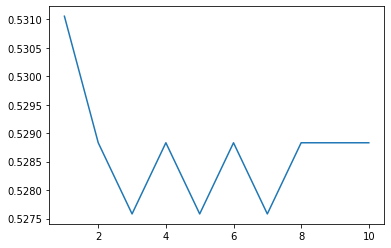

In [29]:
epochs = 10
loss_arr = train(type_optimizer='RMSprop', epochs = epochs)
plot(loss_arr)

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): Softmax(dim=None)
  )
)


/home/avani.gupta/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | loss: 0.5365407991409302
Epoch: 2 | loss: 0.5365230417251587
Epoch: 3 | loss: 0.5365087080001831
Epoch: 4 | loss: 0.5364892816543579
Epoch: 5 | loss: 0.536466407775879
Epoch: 6 | loss: 0.5364475154876709
Epoch: 7 | loss: 0.5364207267761231
Epoch: 8 | loss: 0.5363971376419068
Epoch: 9 | loss: 0.5363604927062988
Epoch: 10 | loss: 0.5363198232650757


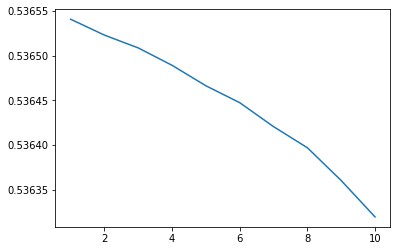

In [30]:
epochs = 10
loss_arr = train(type_optimizer='SGD', epochs = epochs)
plot(loss_arr)

## Data Augmentation

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): Softmax(dim=None)
  )
)


/home/avani.gupta/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | loss: 0.5335429787635804
Epoch: 2 | loss: 0.5273442435264587
Epoch: 3 | loss: 0.526484751701355
Epoch: 4 | loss: 0.5250053548812866
Epoch: 5 | loss: 0.5218956255912781
Epoch: 6 | loss: 0.5215629696846008
Epoch: 7 | loss: 0.519661991596222
Epoch: 8 | loss: 0.5181243658065796
Epoch: 9 | loss: 0.5169534587860107
Epoch: 10 | loss: 0.5149200010299683


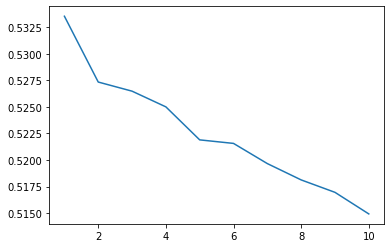

In [31]:
def train(type_optimizer= 'Adam', path = "data/", batch_size = 8, epochs = 20, transform_data_type=0):
    loss_arr = []
     
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print("Using {} device".format(device))
    model = MyNetwork().to(device)
    print(model)
    transform_data =  {
        'images': 
                transforms.Compose([
                transforms.Resize((256, 256), interpolation = transforms.functional.InterpolationMode.BICUBIC),
                transforms.CenterCrop((224, 224)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ]),
        'labels': 
                transforms.Compose([
                transforms.Lambda(lambda y: name_label[y])
                ])
    }
    
    if(transform_data_type == 1):
         transform_data =  {
        'images': 
                transforms.Compose([
                transforms.Resize((256, 256), interpolation = transforms.functional.InterpolationMode.BICUBIC),
                transforms.CenterCrop((224, 224)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transforms.RandomHorizontalFlip(),
                ]),
        'labels': 
                transforms.Compose([
                transforms.Lambda(lambda y: name_label[y]),
                    
                ])
    }
    if(transform_data_type == 2):
         transform_data =  {
        'images': 
                transforms.Compose([
                transforms.Resize((256, 256), interpolation = transforms.functional.InterpolationMode.BICUBIC),
                transforms.CenterCrop((224, 224)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(),
                    
                ]),
        'labels': 
                transforms.Compose([
                transforms.Lambda(lambda y: name_label[y]),
                    
                ])
    }
    
        
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    if(type_optimizer == 'Adagrad'):
        optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-3, weight_decay=1e-4)
    if(type_optimizer == 'SGD'):
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    if(type_optimizer == 'RMSprop'):
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    
    train_dataloader = DataLoader(LoadImageDataset(path + "train.csv", path + "train_images/", transform_data), batch_size = batch_size,  num_workers=2, shuffle=True)
    
    loss_fun = nn.CrossEntropyLoss()
    

    for epoch in range(epochs):
        total_loss = 0
        
        for  dic in train_dataloader:
            X = dic["image"].to(device)
            y = dic["label"].to(device)
            
            # forward pass
            y_preds = model(X)
#             print(y_preds.shape)
            loss = loss_fun(y_preds, y)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
           
        total_loss /= len(train_dataloader.dataset)
        loss_arr.append(total_loss)
        print("Epoch: "+ str(epoch+1) + " | loss: "+str(total_loss), flush = True)
   
    
    return loss_arr


def plot(loss_arr):
    ind = np.arange(1, len(loss_arr)+1)
    plt.plot(ind, np.array(loss_arr))

    
epochs = 10

loss_arr = train(type_optimizer='Adagrad', epochs = epochs)
plot(loss_arr) 

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): Softmax(dim=None)
  )
)


/home/avani.gupta/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | loss: 0.5363215637207032
Epoch: 2 | loss: 0.527514808177948
Epoch: 3 | loss: 0.5284229516983032
Epoch: 4 | loss: 0.5220014095306397
Epoch: 5 | loss: 0.5222182369232178
Epoch: 6 | loss: 0.522419719696045
Epoch: 7 | loss: 0.5195842242240906
Epoch: 8 | loss: 0.513704047203064
Epoch: 9 | loss: 0.5238337540626525
Epoch: 10 | loss: 0.5244262051582337


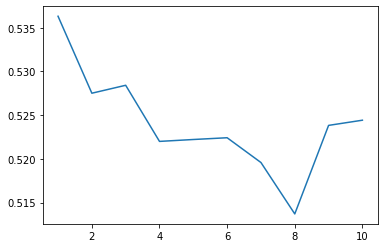

In [32]:
epochs = 10
loss_arr = train(epochs = epochs, transform_data_type=1)
plot(loss_arr) 

Using cpu device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=62, bias=True)
    (10): Softmax(dim=None)
  )
)


/home/avani.gupta/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | loss: 0.5328909468650818
Epoch: 2 | loss: 0.5282698059082032
Epoch: 3 | loss: 0.5322217822074891
Epoch: 4 | loss: 0.5253687191009522
Epoch: 5 | loss: 0.5263639259338379
Epoch: 6 | loss: 0.5243204593658447
Epoch: 7 | loss: 0.5227575421333313
Epoch: 8 | loss: 0.5189781141281128
Epoch: 9 | loss: 0.5202006101608276
Epoch: 10 | loss: 0.5171976900100708


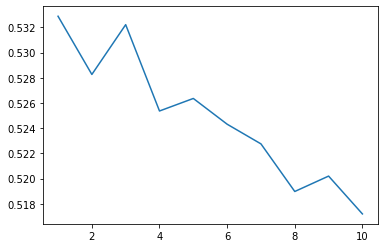

In [33]:
epochs = 10
loss_arr = train(epochs = epochs, transform_data_type=2)
plot(loss_arr) 

### **With Batch Norm**
* Batch normalization regularizes the network which prevents overfitting.
* Helps in resolving vanishing gradient problem.
* Faster convergences and better performance.


### **Adding new layers**
* Might increase perfomance (as visible from loss graphs)
* Chances of overfitting.


### **With Dropout**
* Regulation method.
* Reduces overfitting.
* Drop some of neurons randomly.
* Improved loss in some cases as shown.

### **Different activation functions at the end**
* **Softmax**
 $$\text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)} $$
    * Used in Multi-class classification.
    * Softmax activation gives a probability distribution (the outputs sum to one and each output is between 0-1)
    * Thus we use Softmax at end layer when class labels are mutually exclusive(which is in our case!)

    
    
<!-- * **KL Divergence**
![caption](attachments/KL.png)
    * Measures distance between probability distributions.

     -->
    
Note: Sigmoid is used in binary classification (hence can'nt be used in our case)
 $$ h_ \theta (x) = \frac{\mathrm{1} }{\mathrm{1} + e^- \theta^Tx }$$

* Leaky ReLU and ReLU were tried in between layers. Leaky Relu helps prevent vanishing gradient problem and thus helped in loss.


### **Different pooling strategies**
* **Max pooling**
    * Max pooling is a sample-based discretization process. 
    * Used to reduce dimensionality of feature maps.
    * Takes max operator over sliding window.
* **Avg Pooling**
    * Takes Avg operator over sliding window.
    
Average pooling was found to perfom better.

### **Different optimizers**
* **SGD**
    * Stochastic Gradience Descent
    * Suffers from vanishing gradient problem.
    
* **RMSProp**
    * Helps in vanishing gradient.
    * Uses an adaptive learning rate
    * Uses a moving average of squared gradients to normalize the gradient. 
    * This normalization balances the step size  (momentum)
    * Decreases the step for large gradients to avoid exploding
    * Increases the step for small gradients to avoid vanishing. 

* **Adagrad (Adaptive Gradient Algorithm)**
    * For a sparse feature input where most of the values are zero, we can afford a higher learning rate which will boost the dying gradient resulted from these sparse features. If we have dense data, then we can have slower learning. 
    * Adjusts the learning rate according to values of gradient incurred.
    * When larger updates take smaller learning rate.
    * When smaller updates increase learning rate.

* **Adam**
    * Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.
    * Adam is relatively easy to configure where the default configuration parameters do well on most problems.
    
 
SGD Could'nt converge well.

We observed the best convergence and model performance in Adam.


   

### **Basic Augmentation like Rotation, Translation, Color Change**
* Augmentation is used to add robustness to the train data. 
* Helps to improve the performance of model.

